In [53]:
import numpy as np

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def tanh(x):
    x = np.clip(x, -500, 500)
    return np.tanh(x)

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh_derivative(x):
    return 1 - tanh(x)**2

class GRUCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Xavier/Glorot initialization
        limit = np.sqrt(6 / (input_dim + hidden_dim))
        self.Wz = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Uz = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.bz = np.zeros((hidden_dim, 1))

        self.Wr = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Ur = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.br = np.zeros((hidden_dim, 1))

        self.Wh = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Uh = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.bh = np.zeros((hidden_dim, 1))

        # Adam optimizer parameters
        self.m = {param: np.zeros_like(getattr(self, param)) for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']}
        self.v = {param: np.zeros_like(getattr(self, param)) for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']}
        self.t = 0

        self.reset_gradients()

    def reset_gradients(self):
        self.dWz = np.zeros_like(self.Wz)
        self.dUz = np.zeros_like(self.Uz)
        self.dbz = np.zeros_like(self.bz)
        self.dWr = np.zeros_like(self.Wr)
        self.dUr = np.zeros_like(self.Ur)
        self.dbr = np.zeros_like(self.br)
        self.dWh = np.zeros_like(self.Wh)
        self.dUh = np.zeros_like(self.Uh)
        self.dbh = np.zeros_like(self.bh)

    def forward(self, x, h_prev):
        # Ensure x is 2D
        if x.ndim == 1:
            x = x.reshape(-1, 1)

        # Gerbang update
        self.z = sigmoid(np.dot(self.Wz, x) + np.dot(self.Uz, h_prev) + self.bz)

        # Gerbang reset
        self.r = sigmoid(np.dot(self.Wr, x) + np.dot(self.Ur, h_prev) + self.br)

        # Kandidat state tersembunyi
        self.h_tilde = tanh(np.dot(self.Wh, x) + np.dot(self.Uh, (self.r * h_prev)) + self.bh)

        # State tersembunyi akhir
        h = (1 - self.z) * h_prev + self.z * self.h_tilde

        self.x, self.h_prev, self.h = x, h_prev, h
        return h

    def backward(self, dh_next):
        dz = dh_next * (self.h_tilde - self.h_prev) * sigmoid_derivative(self.z)
        dh_tilde = dh_next * self.z * tanh_derivative(self.h_tilde)
        dr = dh_tilde * np.dot(self.Uh.T, self.h_prev) * sigmoid_derivative(self.r)

        self.dWz += np.dot(dz, self.x.T)
        self.dUz += np.dot(dz, self.h_prev.T)
        self.dbz += np.sum(dz, axis=1, keepdims=True)

        self.dWr += np.dot(dr, self.x.T)
        self.dUr += np.dot(dr, self.h_prev.T)
        self.dbr += np.sum(dr, axis=1, keepdims=True)

        self.dWh += np.dot(dh_tilde, self.x.T)
        self.dUh += np.dot(dh_tilde, (self.r * self.h_prev).T)
        self.dbh += np.sum(dh_tilde, axis=1, keepdims=True)

        dh_prev = (1 - self.z) * dh_next + np.dot(self.Uz.T, dz) + np.dot(self.Ur.T, dr) + np.dot(self.Uh.T, (dh_tilde * self.r))
        return dh_prev

    def update_weights(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.t += 1

        for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']:
            grad = getattr(self, 'd' + param)

            # Gradient clipping
            np.clip(grad, -1.0, 1.0, out=grad)

            # Adam update
            self.m[param] = beta1 * self.m[param] + (1 - beta1) * grad
            self.v[param] = beta2 * self.v[param] + (1 - beta2) * (grad ** 2)

            m_hat = self.m[param] / (1 - beta1 ** self.t)
            v_hat = self.v[param] / (1 - beta2 ** self.t)

            update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

            setattr(self, param, getattr(self, param) - update)

        self.reset_gradients()

print("Fungsi Perhitungan GRU Sudah disiapkan")

Fungsi Perhitungan GRU Sudah disiapkan


Training data shape: (1691, 10, 1)
Validation data shape: (423, 10, 1)
Testing data shape: (529, 10, 1)


Epoch 1/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.14it/s]


Epoch 1/20, Train Loss: 2017.0978, Val Loss: 1096.9781


Epoch 2/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.47it/s]


Epoch 2/20, Train Loss: 4408.8321, Val Loss: 1107.7208


Epoch 3/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.46it/s]


Epoch 3/20, Train Loss: 4413.2370, Val Loss: 1107.7211


Epoch 4/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 24.25it/s]


Epoch 4/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 5/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 24.47it/s]


Epoch 5/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 6/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.00it/s]


Epoch 6/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 7/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.26it/s]


Epoch 7/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 8/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.37it/s]


Epoch 8/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 9/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.08it/s]


Epoch 9/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 10/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.02it/s]


Epoch 10/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 11/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.20it/s]


Epoch 11/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 12/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.20it/s]


Epoch 12/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 13/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.24it/s]


Epoch 13/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 14/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.23it/s]


Epoch 14/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 15/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.18it/s]


Epoch 15/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 16/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.46it/s]


Epoch 16/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 17/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.24it/s]


Epoch 17/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 18/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.21it/s]


Epoch 18/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 19/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 25.36it/s]


Epoch 19/20, Train Loss: 4413.2371, Val Loss: 1107.7211


Epoch 20/20 (Training): 100%|██████████| 53/53 [00:02<00:00, 24.77it/s]


Epoch 20/20, Train Loss: 4413.2371, Val Loss: 1107.7211


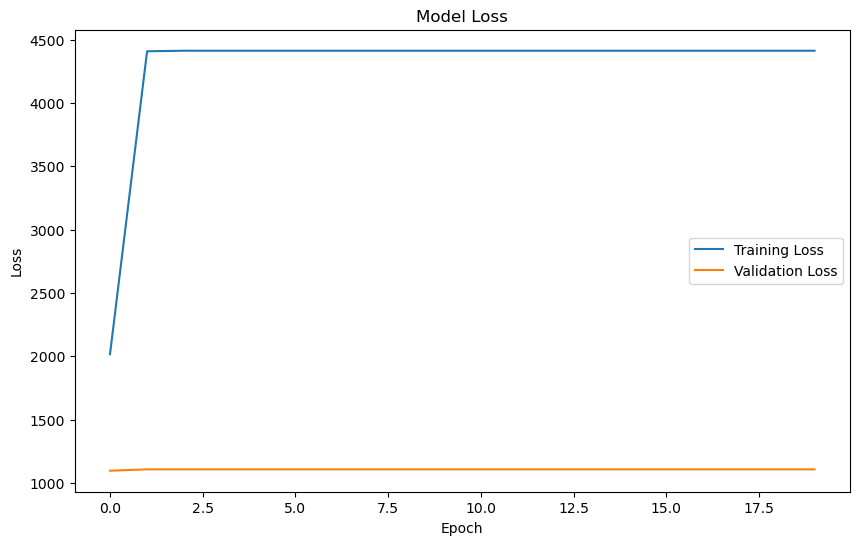

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

def load_and_prepare_data(file_path, column_name, seq_length, test_size=0.2, val_size=0.2):
    try:
        # Load data from Excel file
        data = pd.read_excel(file_path)

        # Extract specified column
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the Excel file.")

        raw_data = data[column_name].values

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_data = scaler.fit_transform(raw_data.reshape(-1, 1))

        # Prepare sequences
        X, y = [], []
        for i in range(len(normalized_data) - seq_length):
            X.append(normalized_data[i:i+seq_length])
            y.append(normalized_data[i+seq_length])

        X, y = np.array(X), np.array(y)

        # Reshape X to be [samples, time steps, features]
        X = X.reshape(X.shape[0], X.shape[1], 1)

        # First, split into training+validation and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Then split the training set into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        print(f"Testing data shape: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test, scaler

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

def train_gru(X_train, y_train, X_val, y_val, input_dim, hidden_dim, epochs=20, learning_rate=0.001, batch_size=32):
    gru = GRUCell(input_dim, hidden_dim)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        # Training
        for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            batch_loss = 0
            for j in range(len(batch_X)):
                x_seq = batch_X[j]
                y_true = batch_y[j]

                # Forward pass
                h = np.zeros((hidden_dim, 1))
                for t in range(x_seq.shape[0]):
                    x_t = x_seq[t].reshape(-1, 1)
                    h = gru.forward(x_t, h)

                # Calculate loss (mean squared error)
                y_pred = h[-1][0]
                loss = (y_true - y_pred)**2
                batch_loss += loss

                # Backward pass
                dh_next = 2 * (y_pred - y_true)
                for t in reversed(range(x_seq.shape[0])):
                    x_t = x_seq[t].reshape(-1, 1)
                    dh_next = gru.backward(dh_next)

            # Update weights
            gru.update_weights(learning_rate)
            total_train_loss += batch_loss

        # Validation
        for i in range(len(X_val)):
            x_seq = X_val[i]
            y_true = y_val[i]

            # Forward pass
            h = np.zeros((hidden_dim, 1))
            for t in range(x_seq.shape[0]):
                x_t = x_seq[t].reshape(-1, 1)
                h = gru.forward(x_t, h)

            # Calculate loss
            y_pred = h[-1][0]
            loss = (y_true - y_pred)**2
            total_val_loss += loss

        # Record losses
        avg_train_loss = float(np.mean(total_train_loss))
        avg_val_loss = float(np.mean(total_val_loss))
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return gru, history

# Usage
file_path = 'main_data.xlsx'
column_name = 'Terakhir_IDR'
seq_length = 10

X_train, X_val, X_test, y_train, y_val, y_test, scaler = load_and_prepare_data(file_path, column_name, seq_length)

input_dim = X_train.shape[2]
hidden_dim = 100
gru, history = train_gru(X_train, y_train, X_val, y_val, input_dim, hidden_dim)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
import pickle

# Fungsi untuk menyimpan model dan scaler
def save_model(gru, scaler, filename_model, filename_scaler):
    with open(filename_model, 'wb') as f_model:
        pickle.dump(gru, f_model)
    with open(filename_scaler, 'wb') as f_scaler:
        pickle.dump(scaler, f_scaler)

# Fungsi untuk memuat model dan scaler
def load_model(filename_model, filename_scaler):
    with open(filename_model, 'rb') as f_model:
        gru = pickle.load(f_model)
    with open(filename_scaler, 'rb') as f_scaler:
        scaler = pickle.load(f_scaler)
    return gru, scaler

# Simpan model dan scaler setelah pelatihan
save_model(gru, scaler, 'gru_model.pkl', 'scaler.pkl')

# Contoh memuat model dan scaler
loaded_gru, loaded_scaler = load_model('gru_model.pkl', 'scaler.pkl')


Hasil prediksi telah disimpan ke prediksi_hasil.xlsx


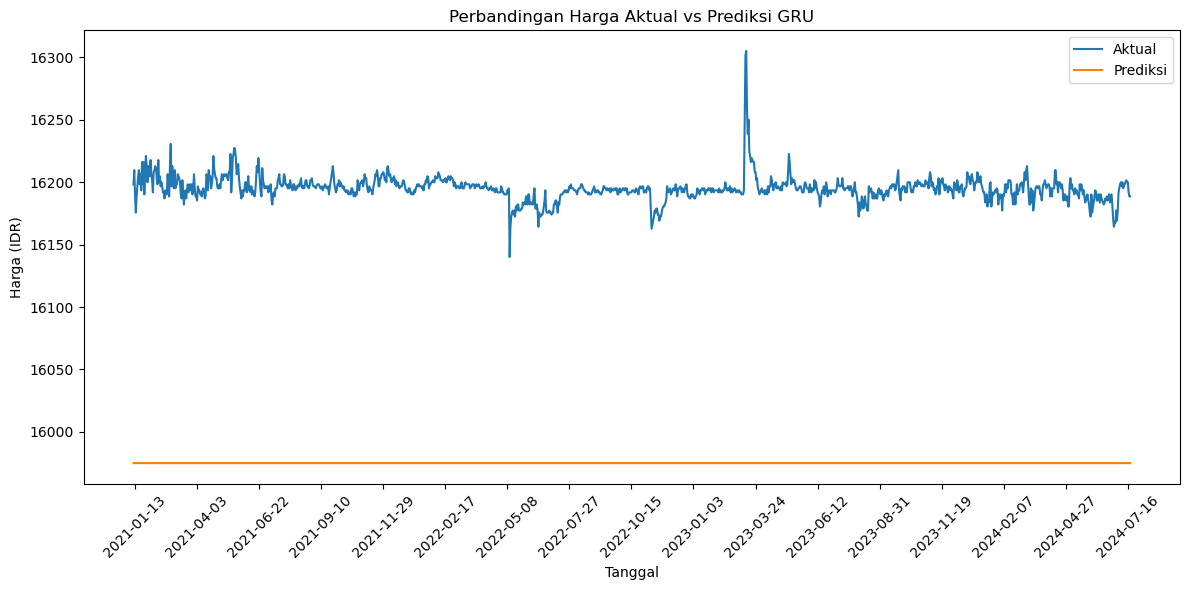

In [52]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler

# Fungsi tambahan untuk menghitung MAPE dan MPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

# Load the scaler and model
with open('gru_model.pkl', 'rb') as f:
    loaded_gru = pickle.load(f)

# Define the file paths and parameters
file_path = 'hasil_prediksi.xlsx'  # Path to your uploaded test data file
output_file_path = 'prediksi_hasil.xlsx'
seq_length = 10

# Load and prepare the test data
test_data = pd.read_excel(file_path)
test_data['Tanggal'] = pd.to_datetime(test_data['Tanggal'], format='%d/%m/%Y')  # Adjust the format to match your data
test_data_close = test_data['Terakhir_IDR'].values  # Adjust the column name as needed

# Fit the scaler with test data (or load pre-fitted scaler if available)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(test_data_close.reshape(-1, 1))  # Fit the scaler with the test data

# Normalize test data using the fitted scaler
test_data_normalized = scaler.transform(test_data_close.reshape(-1, 1))

# Fungsi prediksi
def make_predictions(model, data, seq_length):
    predictions = []
    h = np.zeros((model.hidden_dim, 1))  # Initial hidden state
    for i in range(len(data) - seq_length):
        x_seq = data[i:i + seq_length]
        for t in range(seq_length):
            x_t = x_seq[t].reshape(-1, 1)
            h = model.forward(x_t, h)
        y_pred = h[-1][0]
        predictions.append(y_pred)
    return np.array(predictions)

# Buat prediksi
predictions = make_predictions(loaded_gru, test_data_normalized, seq_length)

# Denormalisasi hasil prediksi
predictions_denormalized = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Buat dataframe hasil prediksi
results = pd.DataFrame({
    'Tanggal': test_data['Tanggal'][seq_length:].values[:len(predictions)],
    'data_close': test_data_close[seq_length:][:len(predictions)],
    'prediksi_close': predictions_denormalized,
})

# Hitung selisih dan persentase selisih
results['selisih'] = results['data_close'] - results['prediksi_close']
results['persentase_selisih'] = (results['selisih'] / results['data_close']) * 100

# Hitung MAE, RMSE, MAPE, dan MPE
mae = mean_absolute_error(results['data_close'], results['prediksi_close'])
rmse = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close']))
mape = mean_absolute_percentage_error(results['data_close'], results['prediksi_close'])
mpe = mean_percentage_error(results['data_close'], results['prediksi_close'])

# Buat dataframe untuk menampilkan hasil metrik
metrics = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'MPE'],
    'Value': [mae, rmse, mape, mpe]
})

# Tampilkan dataframe metrik dalam Jupyter Notebook
metrics
# Simpan hasil prediksi
results.to_excel(output_file_path, index=False)
print(f"Hasil prediksi telah disimpan ke {output_file_path}")

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(results['Tanggal'], results['data_close'], label='Aktual')
plt.plot(results['Tanggal'], results['prediksi_close'], label='Prediksi')

# Menampilkan tanggal hanya dengan bulan dan tahun untuk menghindari overlap
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))

plt.title('Perbandingan Harga Aktual vs Prediksi GRU')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


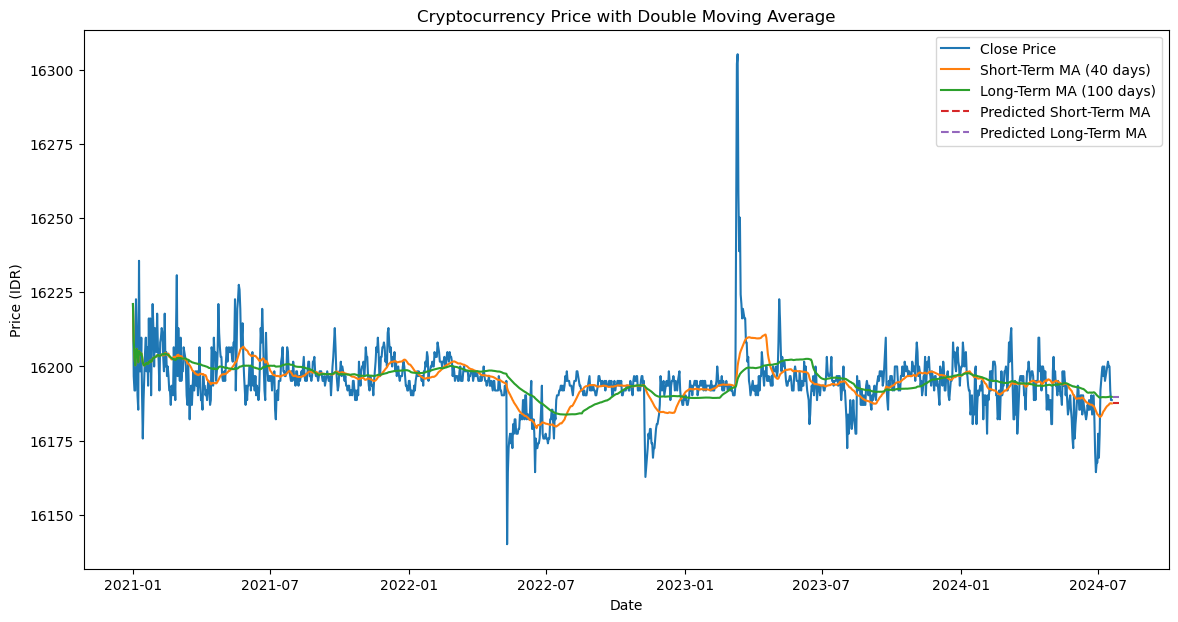

,Metric,Value
0,MAE_Short_MA,5.545371
1,RMSE_Short_MA,8.774104
2,MAPE_Short_MA,0.034234
3,MSE_Short_MA,76.984897
4,MAE_Long_MA,6.203171
5,RMSE_Long_MA,9.401284
6,MAPE_Long_MA,0.038297
7,MSE_Long_MA,88.384147


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_data(file_path):
    # Memuat data cryptocurrency dari file Excel
    data = pd.read_excel(file_path)
    data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')
    data.set_index('Tanggal', inplace=True)
    return data

def calculate_moving_averages(data, short_window, long_window):
    # Menghitung moving average jangka pendek dan jangka panjang
    data['Short_MA'] = data['Terakhir_IDR'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Terakhir_IDR'].rolling(window=long_window, min_periods=1).mean()
    return data

def predict_dma(data, short_window, long_window, prediction_window):
    # Memprediksi tren masa depan berdasarkan DMA
    short_ma_future = [data['Short_MA'].iloc[-1]] * prediction_window
    long_ma_future = [data['Long_MA'].iloc[-1]] * prediction_window
    return short_ma_future, long_ma_future

def save_to_excel(data, output_file_path):
    # Menyimpan data yang telah diproses ke file Excel
    data.to_excel(output_file_path, index=True)

def plot_data(data, short_window, long_window, short_ma_future, long_ma_future):
    # Memplot harga penutupan dan moving average
    plt.figure(figsize=(14, 7))
    plt.plot(data['Terakhir_IDR'], label='Close Price')
    plt.plot(data['Short_MA'], label=f'Short-Term MA ({short_window} days)')
    plt.plot(data['Long_MA'], label=f'Long-Term MA ({long_window} days)')

    # Menyiapkan tanggal untuk prediksi moving average
    future_dates = pd.date_range(start=data.index[-1], periods=len(short_ma_future) + 1, freq='D')[1:]
    plt.plot(future_dates, short_ma_future, '--', label='Predicted Short-Term MA')
    plt.plot(future_dates, long_ma_future, '--', label='Predicted Long-Term MA')

    # Menambahkan judul dan label pada plot
    plt.title('Cryptocurrency Price with Double Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (IDR)')
    plt.legend()
    plt.show()

# Fungsi tambahan untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Jalur file ke file Excel
file_path = 'hasil_prediksi.xlsx'
output_file_path = 'hasil_dma.xlsx'
short_window = 40
long_window = 100
prediction_window = 10  # Jumlah hari untuk prediksi

# Memuat data
data = load_data(file_path)

# Menghitung moving averages
data = calculate_moving_averages(data, short_window, long_window)

# Menambahkan kolom selisih dan persentase selisih antara Short MA dan Long MA dengan harga asli
data['Selisih_Short_MA'] = data['Terakhir_IDR'] - data['Short_MA']
data['Persentase_Selisih_Short_MA'] = (data['Selisih_Short_MA'] / data['Terakhir_IDR']) * 100

data['Selisih_Long_MA'] = data['Terakhir_IDR'] - data['Long_MA']
data['Persentase_Selisih_Long_MA'] = (data['Selisih_Long_MA'] / data['Terakhir_IDR']) * 100

# Menghitung metrik
metrics = {
    'MAE_Short_MA': mean_absolute_error(data['Terakhir_IDR'], data['Short_MA']),
    'RMSE_Short_MA': np.sqrt(mean_squared_error(data['Terakhir_IDR'], data['Short_MA'])),
    'MAPE_Short_MA': mean_absolute_percentage_error(data['Terakhir_IDR'], data['Short_MA']),
    'MSE_Short_MA': mean_squared_error(data['Terakhir_IDR'], data['Short_MA']),
    'MAE_Long_MA': mean_absolute_error(data['Terakhir_IDR'], data['Long_MA']),
    'RMSE_Long_MA': np.sqrt(mean_squared_error(data['Terakhir_IDR'], data['Long_MA'])),
    'MAPE_Long_MA': mean_absolute_percentage_error(data['Terakhir_IDR'], data['Long_MA']),
    'MSE_Long_MA': mean_squared_error(data['Terakhir_IDR'], data['Long_MA']),
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Menyimpan data yang telah diproses ke file Excel baru
save_to_excel(data, output_file_path)

# Memplot data
plot_data(data, short_window, long_window, short_ma_future, long_ma_future)

metrics_df



Hasil prediksi dan perbandingan metrik telah disimpan ke hasil_dma.xlsx


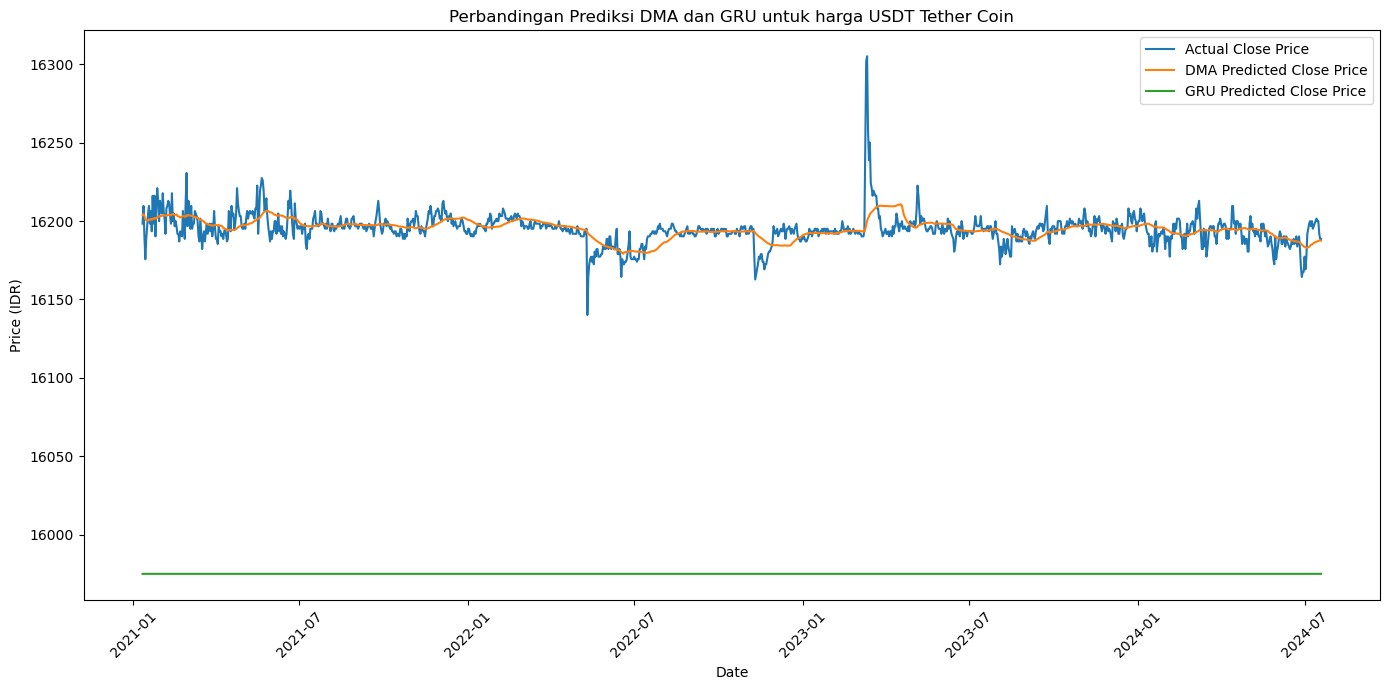

,Metric,DMA,GRU
0,MAE,5.494285,220.014681
1,RMSE,8.715295,220.234729
2,MAPE,0.033918,1.358503
3,MPE,-0.001262,1.358503


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Buat prediksi menggunakan model GRU yang sudah dimuat
gru_predictions = make_predictions(loaded_gru, test_data_normalized, seq_length)
gru_predictions_denormalized = scaler.inverse_transform(gru_predictions.reshape(-1, 1)).flatten()

# Hitung DMA (Double Moving Average)
data = calculate_moving_averages(test_data, short_window, long_window)
predictions_denormalized = data['Short_MA'].iloc[seq_length:].values

# Update dataframe hasil dengan prediksi GRU dan DMA
results = pd.DataFrame({
    'Tanggal': test_data['Tanggal'][seq_length:].values,
    'data_close': test_data_close[seq_length:],
    'prediksi_close_dma': predictions_denormalized,
    'prediksi_close_gru': gru_predictions_denormalized,
})

# Hitung selisih dan persentase selisih
results['selisih_dma'] = results['data_close'] - results['prediksi_close_dma']
results['persentase_selisih_dma'] = (results['selisih_dma'] / results['data_close']) * 100
results['selisih_gru'] = results['data_close'] - results['prediksi_close_gru']
results['persentase_selisih_gru'] = (results['selisih_gru'] / results['data_close']) * 100

# Hitung metrik kinerja
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

mae_dma = mean_absolute_error(results['data_close'], results['prediksi_close_dma'])
rmse_dma = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close_dma']))
mape_dma = mean_absolute_percentage_error(results['data_close'], results['prediksi_close_dma'])
mpe_dma = mean_percentage_error(results['data_close'], results['prediksi_close_dma'])

mae_gru = mean_absolute_error(results['data_close'], results['prediksi_close_gru'])
rmse_gru = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close_gru']))
mape_gru = mean_absolute_percentage_error(results['data_close'], results['prediksi_close_gru'])
mpe_gru = mean_percentage_error(results['data_close'], results['prediksi_close_gru'])

# Tabel perbandingan metrik kinerja
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'MPE'],
    'DMA': [mae_dma, rmse_dma, mape_dma, mpe_dma],
    'GRU': [mae_gru, rmse_gru, mape_gru, mpe_gru]
})

# Simpan hasil prediksi dan perbandingan metrik ke file Excel
with pd.ExcelWriter(output_file_path) as writer:
    results.to_excel(writer, sheet_name='Predictions', index=False)
    metrics_comparison.to_excel(writer, sheet_name='Metrics_Comparison', index=False)

print(f"Hasil prediksi dan perbandingan metrik telah disimpan ke {output_file_path}")

# Visualisasi perbandingan prediksi
plt.figure(figsize=(14, 7))
plt.plot(results['Tanggal'], results['data_close'], label='Actual Close Price')
plt.plot(results['Tanggal'], results['prediksi_close_dma'], label='DMA Predicted Close Price')
plt.plot(results['Tanggal'], results['prediksi_close_gru'], label='GRU Predicted Close Price')

plt.title('Perbandingan Prediksi DMA dan GRU untuk harga USDT Tether Coin')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

metrics_comparison
